In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve

In [ ]:
with open("../data/scores_results.json", "r") as f:
    scores = json.load(f)

with open("../data/regression_results.json", "r") as f:
    regs = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'scores_results.json'

In [3]:
def sum_ue(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    m = min(len(a), len(b))
    return a[:m] + b[:m]
    
def min(a, b):
    return np.minimum(a, b)

def max(a, b):
    return np.maximum(a, b)

def avg(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    return (a + b) / 2

def havg(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    return 2 / ((1 / a) + (1 / b))

In [ ]:
def get_xlabel(reg):
    return {
        'ue1' : 'SumEigV',
        'ue2' : 'Second UE',
        'sum' : 'SumEigV + ',
        'max' : 'max(SumEigV, )',
        'min' : 'min(SumEigV, )',
        'avg' : 'Average of UEs',
        'havg' : 'Harmonic Average of UEs'
    }[reg]


def get_xs(reg, d):
    ue1 = d["ue1"]
    ue2 = d["ue2"]

    return {
        "ue1": ue1,
        'ue2' : ue2,
        'sum' : sum_ue(ue1, ue2),
        'max' : max(ue1, ue2),
        'min' : min(ue1, ue2),
        'avg' : avg(ue1, ue2),
        'havg' : havg(ue1, ue2)
    }[reg]

In [ ]:
# TEST VALUES
scores = {
    "Q1": {
        "ue1": [0.2, 0.5, 0.8],
        "ue2": [1.0, 0.9, 1.1],
        "safe_scores": [0, 1, 1]
    },
    "Q2": {
        "ue1": [0.3, 0.4],
        "ue2": [1.2, 1.05],
        "safe_scores": [1, 0]
    }
}


# regs = {
#     "ue1":  {"slope": 1.2, "intercept": 0.1, "correlation": 0.7},
#     "ue2":  {"slope": -0.4, "intercept": 1.0, "correlation": -0.3},
#     "sum":  {"slope": 0.8, "intercept": 0.2, "correlation": 0.5},
#     "min":  {"slope": 1.1, "intercept": -0.1, "correlation": 0.6},
#     "max":  {"slope": -0.7, "intercept": 1.3, "correlation": -0.4},
#     "avg":  {"slope": 0.5, "intercept": 0.4, "correlation": 0.4},
#     "havg": {"slope": 0.2, "intercept": 0.6, "correlation": 0.2}
# }


In [1]:
# TEST VALUES
final_answer = {
    "Q1": {
        "ue1": [0.2, 0.5, 0.8],
        "ue2": [1.0, 0.9, 1.1],
        "safe_scores": [0, 1, 1]
    },
    "Q2": {
        "ue1": [0.3, 0.4],
        "ue2": [1.2, 1.05],
        "safe_scores": [1, 0]
    }
}


In [ ]:
def compute_roc_analysis(final_answers, ensemble_funcs=None):
    """
    Computes ROC-AUC score for individual Uncertainty Estimates (UEs) 
    and their ensembles against binary safety scores.

    Args:
        final_answers (dict): A dictionary where values are dicts containing 
                              "ue1", "ue2", and "safe_scores" lists.
        ensemble_funcs (list, optional): A list of functions for combining ue1 and ue2.
                                        Defaults to None.

    Returns:
        dict: A dictionary of results containing 'roc_auc' for each method, 
              and the corresponding 'fpr', 'tpr', and 'thresholds'.
    """
    all_ue1 = []
    all_ue2 = []
    all_safe_scores = []

    results = {}

    # 1. Gather all scores from the input dictionary
    for _, scores in final_answers.items():
        # UEs are the predicted scores (higher UE = higher predicted 'unsafe' probability)
        all_ue1.extend(scores["ue1"]) 
        all_ue2.extend(scores["ue2"]) 
        
        # Safety scores are the binary truth labels (e.g., 0 for safe, 1 for unsafe)
        all_safe_scores.extend(scores["safe_scores"])

    # Convert to numpy arrays
    ue1 = np.array(all_ue1)
    ue2 = np.array(all_ue2)
    safe_labels = np.array(all_safe_scores) # The 'True' binary labels

    # --- 2. Process Individual UEs ---

    # UE1 Analysis
    fpr1, tpr1, thresholds1 = roc_curve(safe_labels, ue1)
    auc1 = roc_auc_score(safe_labels, ue1)
    results["ue1"] = {"roc_auc": auc1, "fpr": fpr1, "tpr": tpr1, "thresholds": thresholds1}
    
    # UE2 Analysis
    # Renaming 'p_true2ue' to 'ue2' for consistency in the code logic
    fpr2, tpr2, thresholds2 = roc_curve(safe_labels, ue2)
    auc2 = roc_auc_score(safe_labels, ue2)
    results["ue2"] = {"roc_auc": auc2, "fpr": fpr2, "tpr": tpr2, "thresholds": thresholds2}

    # --- 3. Process Ensembles ---
    if ensemble_funcs is not None:
        for f in ensemble_funcs:
            # Calculate the ensemble score
            ue_ensemble = f(ue1, ue2)
            
            # Compute ROC
            fpr_e, tpr_e, thresholds_e = roc_curve(safe_labels, ue_ensemble)
            auc_e = roc_auc_score(safe_labels, ue_ensemble)

            # Store results
            name = getattr(f, "__name__", str(f))
            results[name] = {"roc_auc": auc_e, "fpr": fpr_e, "tpr": tpr_e, "thresholds": thresholds_e}

    return results


res = compute_roc_analysis(final_answers=final_answer, ensemble_funcs=[sum, min, max, avg, havg])

In [5]:
print(res)

{'ue1': {'roc_auc': 0.8333333333333333, 'fpr': array([0. , 0. , 0. , 0.5, 0.5, 1. ]), 'tpr': array([0.        , 0.33333333, 0.66666667, 0.66666667, 1.        ,
       1.        ]), 'thresholds': array([inf, 0.8, 0.5, 0.4, 0.3, 0.2])}, 'ue2': {'roc_auc': 0.6666666666666666, 'fpr': array([0., 0., 0., 1., 1.]), 'tpr': array([0.        , 0.33333333, 0.66666667, 0.66666667, 1.        ]), 'thresholds': array([inf, 1.2, 1.1, 1. , 0.9])}, 'sum': {'roc_auc': 0.6666666666666666, 'fpr': array([0., 0., 0., 1., 1.]), 'tpr': array([0.        , 0.33333333, 0.66666667, 0.66666667, 1.        ]), 'thresholds': array([inf, 3.4, 3.3, 3.2, 3.1])}, 'min': {'roc_auc': 0.8333333333333333, 'fpr': array([0. , 0. , 0. , 0.5, 0.5, 1. ]), 'tpr': array([0.        , 0.33333333, 0.66666667, 0.66666667, 1.        ,
       1.        ]), 'thresholds': array([inf, 0.8, 0.5, 0.4, 0.3, 0.2])}, 'max': {'roc_auc': 0.6666666666666666, 'fpr': array([0., 0., 0., 1., 1.]), 'tpr': array([0.        , 0.33333333, 0.66666667, 0.6666

ROC plots generated and saved as PNG files.


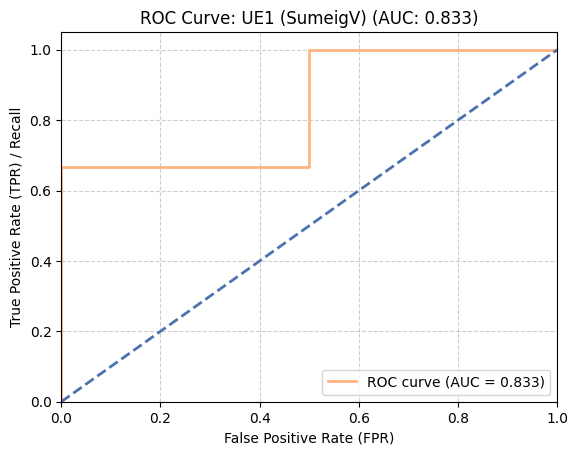

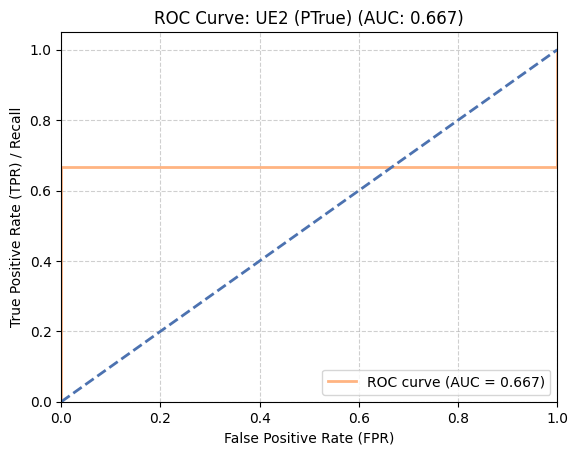

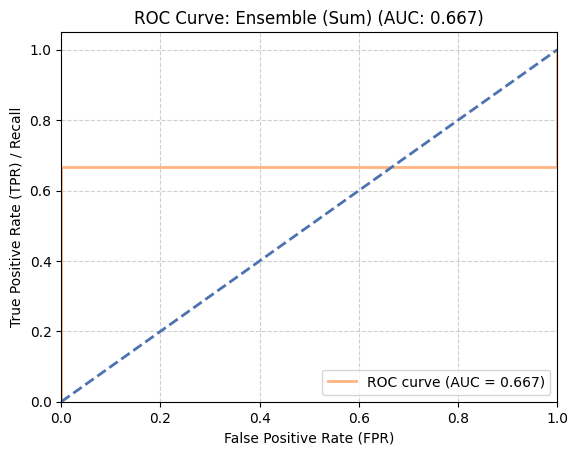

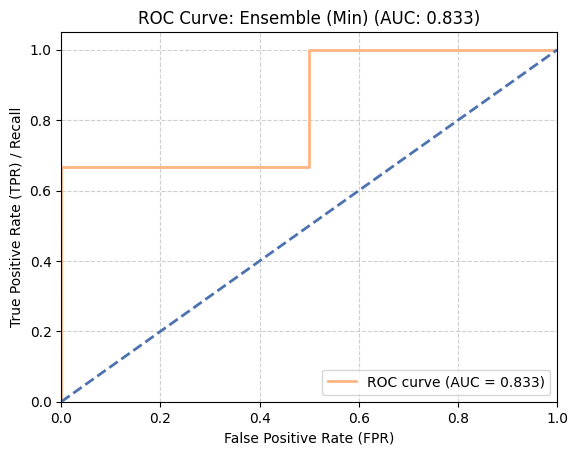

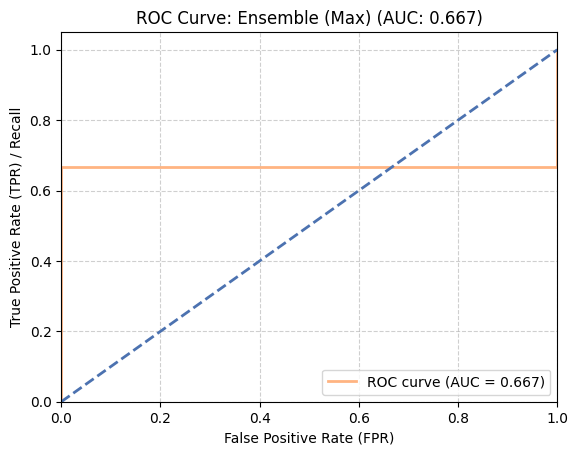

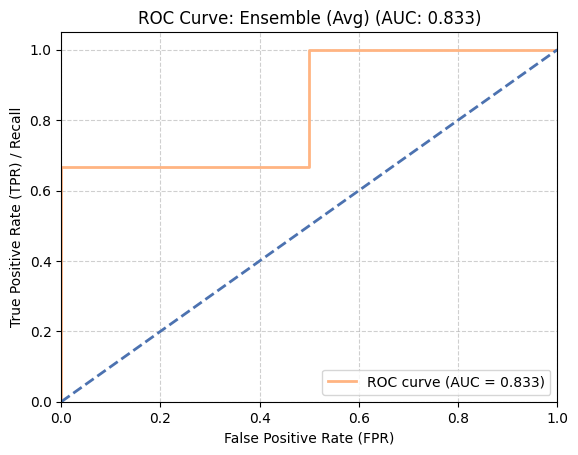

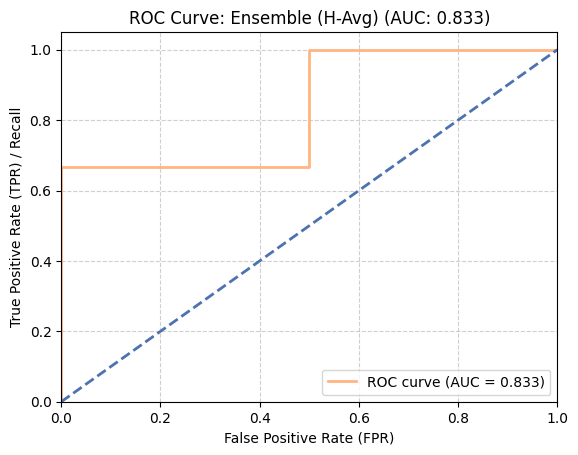

In [ ]:
def generate_mock_roc_data(auc_val, n_points=50):
    """Generates smooth, mock ROC data for plotting."""
    # Create fake labels (0 or 1)
    y_true = np.random.randint(0, 2, 500)
    # Create fake scores (closer to 1.0 for the positive class)
    if auc_val > 0.5:
        y_scores = y_true + np.random.normal(0, 0.5 * (1.0 - auc_val), 500)
    else:
        y_scores = (1 - y_true) + np.random.normal(0, 0.5 * auc_val, 500)
    
    # Clip scores to [0, 1] for a clean curve
    y_scores = np.clip(y_scores, 0.0, 1.0)
    
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    
    return {
        "roc_auc": roc_auc_score(y_true, y_scores),
        "fpr": fpr,
        "tpr": tpr,
        "thresholds": thresholds
    }

eg_keys = ['ue1', 'ue2', 'sum', 'min', 'max', 'avg', 'havg']

palette1 = sns.color_palette("pastel")
palette = sns.color_palette("deep")

c_random_line = '--' # Style for the random line


c_random= palette[0]
c_line = palette1[1]
c_shade = palette[1]


def get_xlabel(reg_key):
    """Maps the key to a readable plot label."""
    mapping = {
        'ue1': 'UE1 (SumeigV)',
        'ue2': 'UE2 (PTrue)',
        'sum': 'Ensemble (Sum)',
        'min': 'Ensemble (Min)',
        'max': 'Ensemble (Max)',
        'avg': 'Ensemble (Avg)',
        'havg': 'Ensemble (H-Avg)'
    }
    return mapping.get(reg_key, reg_key)
# --- END MOCK SETUP ---


# --- ROC Plotting Loop ---
for reg in eg_keys:
    # 1. Retrieve the pre-calculated ROC metrics
    data = res[reg]
    fpr = data["fpr"]
    tpr = data["tpr"]
    auc = data["roc_auc"]

    # 2. Start a new plot
    plt.figure()

    # 3. Plot the ROC curve (TPR vs FPR)
    # Using the line color constant
    plt.plot(fpr, tpr, color=c_line, lw=2, label=f'ROC curve (AUC = {auc:.3f})')
    plt.fill_between(fpr, tpr, alpha=0.2, color = )

    # 4. Plot the random chance baseline (y=x)
    # This represents an AUC of 0.5
    plt.plot([0, 1], [0, 1], color=c_random, linestyle=c_random_line, lw=2)

    # 5. Set axis limits and labels
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    name = get_xlabel(reg)
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR) / Recall")
    plt.title(f"ROC Curve: {name} (AUC: {auc:.3f})")

    # 6. Add legend and save
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Save the figure using a meaningful filename
    # plt.savefig(f"{reg}_roc_curve.png", dpi=600, bbox_inches="tight")
    # plt.show() # Uncomment to display plots immediately

print("ROC plots generated and saved as PNG files.")